In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np
import torch.optim as optim

import _init_path
from torch.autograd import Variable
from cls.data import ModelNet40, ScanObjectNN
from util import cal_loss

from cls.model_mixup import PointNet, DGCNN, Pointnet2_MSG


parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--model', type=str, default='dgcnn', metavar='N',
                    choices=['pointnet', 'dgcnn', 'pointnet2_MSG'],
                    help='Model to use, [pointnet, dgcnn]')
parser.add_argument('--data', type=str, default='MN40', metavar='N',
                    choices=['MN40', 'SONN_EASY', 'SONN_HARD'])
parser.add_argument('--batch_size', type=int, default=16, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--test_batch_size', type=int, default=128, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--epochs', type=int, default=250, metavar='N',
                    help='number of episode to train ')
parser.add_argument('--optim', type=str, default="sgd",
                    choices=['sgd', 'adam'],
                    help='Optimizer, [sgd, adam]')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001, 0.1 if using sgd)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--scheduler', type=str, default='cos', metavar='N',
                    choices=['cos', 'step'],
                    help='Scheduler to use, [cos, step]')
parser.add_argument('--no_cuda', type=bool, default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--eval', type=bool,  default=False,
                    help='evaluate the model')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='initial dropout rate')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=20, metavar='N',
                    help='Num of nearest neighbors to use')
parser.add_argument('--model_path', type=str, default='', metavar='N',
                    help='Pretrained model path')

parser.add_argument('--aug', type=str, default='default', metavar='N',
                    choices=['default', 'MN40'])
parser.add_argument("--kermix", type=bool, default= False)    
parser.add_argument("--manimix", type=bool, default=False) 
parser.add_argument('--sigma', type=float, default=0.3) 
parser.add_argument('--beta', type=float, default=5.)  
parser.add_argument('--no_saliency', action='store_true')
parser.add_argument('--smoothing_k', type=int, default=20) 
parser.add_argument('--temperature', type=float, default=2)
parser.add_argument('--temperature2', type=float, default=1)  
parser.add_argument('--sample_ver', type=int, default=3) 
args = parser.parse_args([])


num_class = 15

loader = DataLoader(ScanObjectNN(partition='test', num_points=args.num_points, aug=args.aug, ver="easy"), num_workers=4,
                                batch_size=args.test_batch_size, shuffle=True, drop_last=False)

device = torch.device("cuda")

model = DGCNN(args, num_class).to(device)
# model = PointNet(args, num_class).to(device)
model =  nn.DataParallel(model)
model.load_state_dict(torch.load("outputs/SONN_EASY_base/models/model.t7"))
model = model.module
model.eval()


model_our = DGCNN(args, num_class).to(device)
# model = PointNet(args, num_class).to(device)
model_our =  nn.DataParallel(model_our)
model_our.load_state_dict(torch.load("outputs/sample_ver3_dgcnn_SONN_EASY_0.1_beta0.4/models/model.t7"))
model_our = model_our.module
model_our.eval()

model_mix = DGCNN(args, num_class).to(device)
# model = PointNet(args, num_class).to(device)
model_mix =  nn.DataParallel(model_mix)
model_mix.load_state_dict(torch.load("outputs/basemixup_dgcnn_SONNEASY/models/model.t7"))
model_mix = model_mix.module
model_mix.eval()


pass
    

In [2]:
from cls.model import DGCNN
model_RS = DGCNN(args, num_class).to(device)
# model = PointNet(args, num_class).to(device)
model_RS =  nn.DataParallel(model_RS)
model_RS = model_RS.module
model_RS.eval()

model_RS.load_state_dict(torch.load("../../RSMix/dgcnn_rsmix/checkpoints/baseRSmix_rotjit_dgcnn_SONN_EASY/models/model.t7"))

<All keys matched successfully>

In [25]:
num_bins = 10
counts = [0 for _ in range(num_bins+1)]
acc_counts = [0 for _ in range(num_bins+1)]
conf_counts = [0 for _ in range(num_bins+1)]
n = float(len(loader.dataset))*10

for i in range(10):
    # num_bins = 50
    # counts = [0 for _ in range(num_bins+1)]
    # acc_counts = [0 for _ in range(num_bins+1)]
    # conf_counts = [0 for _ in range(num_bins+1)]
    # n = float(len(loader.dataset))
    
    for data, label in loader:
        data, label = data.to(device), label.to(device).squeeze()
        batch_size = data.size()[0]


        with torch.no_grad():
            logits, _ = model(data.permute(0,2,1), mixup=False)
            # logits, _ = model_mix(data.permute(0,2,1))
            # logits, _ = model_our(data.permute(0,2,1), mixup=False)
            # logits= model_RS(data.permute(0,2,1))
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            confs, preds = probabilities.max(1)
            for (conf, pred, target) in zip(confs, preds, label):
                bin_index = int(((conf * 100) // (100/num_bins)).cpu())
                try:
                    if pred == target:
                        acc_counts[bin_index] += 1.0
                    conf_counts[bin_index] += conf.cpu()
                    counts[bin_index] += 1.0
                except:
                    print(bin_index, conf)
                    raise AssertionError('Bin index out of range!')

avg_acc = [0 if count == 0 else acc_count / count for acc_count, count in zip(acc_counts, counts)]
avg_conf = [0 if count == 0 else conf_count / count for conf_count, count in zip(conf_counts, counts)]
ECE, OE = 0, 0
for i in range(num_bins):
    ECE += (counts[i] / n) * abs(avg_acc[i] - avg_conf[i])
    OE += (counts[i] / n) * (avg_conf[i] * (max(avg_conf[i] - avg_acc[i], 0)))

print(ECE, OE)

/tmp/ipykernel_36804/2308846766.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_index = int(((conf * 100) // (100/num_bins)).cpu())


tensor(0.0856) tensor(0.)


In [7]:
a_origin = 1.2692409252350696
a_our = 1.148782700938109
a_rs = 1.17494332656671
a_mix = 0.9265067956843933

[Text(0.5, 0, 'avg_conf'), Text(0, 0.5, 'avg_acc')]

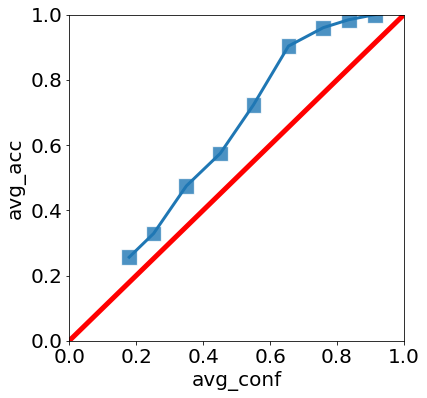

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

plt.rc('font', size=4)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
keep = np.array(counts)>0
x, y =np.array(avg_conf)[keep], np.array(avg_acc)[keep]
a = (y/x).mean()
line = mlines.Line2D([0, 1], [0, 1], color='red', linewidth=5)
# line2 = mlines.Line2D([0, 1], [0, a], color='blue', linewidth=5, alpha =0.5)

sns.scatterplot(x, y, ax=ax, size=x, sizes=(250, 250), alpha=0.8, marker = "s")
ax.plot(x,y, linewidth= 3)



# transform = ax.transAxes
# line.set_transform(transform)
ax.get_legend().remove()
ax.add_line(line)
# ax.add_line(line2)
ax.set(xlabel="Confidence", ylabel="Accuracy")

[Text(0.5, 0, 'avg_conf'), Text(0, 0.5, 'avg_acc')]

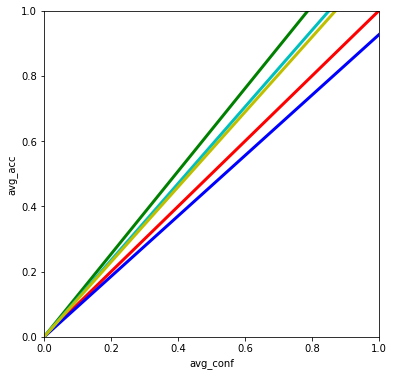

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

x, y =np.array(avg_conf)[keep], np.array(avg_acc)[keep]
a = (y/x).mean()
line = mlines.Line2D([0, 1], [0, 1], color='red', linewidth=3)
line2 = mlines.Line2D([0, 1], [0, a_origin], color='g', linewidth=3)
line3 = mlines.Line2D([0, 1], [0, a_mix], color='blue', linewidth=3)
line4 = mlines.Line2D([0, 1], [0, a_rs], color='c', linewidth=3)
line5 = mlines.Line2D([0, 1], [0, a_our], color='y', linewidth=3)

ax.add_line(line)
ax.add_line(line2)
ax.add_line(line3)
ax.add_line(line4)
ax.add_line(line5)
ax.set(xlabel="avg_conf", ylabel="avg_acc")

In [110]:
a

1.17494332656671

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

x, y =np.array(avg_conf)[keep], np.array(avg_acc)[keep]
a = (y/x).mean()
line = mlines.Line2D([0, 1], [0, 1], color='red', linewidth=3)
line2 = mlines.Line2D([0, 1], [0, a], color='blue', linewidth=3)
keep = np.array(counts)>0
sns.scatterplot(x, y, ax=ax, size=x, sizes=(50, 50), alpha=0.8, marker = "s")
# transform = ax.transAxes
# line.set_transform(transform)
ax.get_legend().remove()
ax.add_line(line)
ax.add_line(line2)
ax.set(xlabel="avg_conf", ylabel="avg_acc")

0.9265067956843933

In [ ]:
len(np.array(avg_conf)[keep]), len(np.array(avg_acc)[keep])

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
line = mlines.Line2D([0, 1], [0, 1], color='red', linewidth=3)
plt.plot(avg_conf[4:-2], avg_acc[4:-2], color="b", marker="s")
# transform = ax.transAxes
# line.set_transform(transform)
# ax.get_legend().remove()
ax.add_line(line)
ax.set(xlabel="avg_conf", ylabel="avg_acc")

In [ ]:
avg_conf